In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', None)

In [2]:
trunk_data = pd.read_csv("")
triton_data = pd.read_csv("triton_results.csv")
cusparse_dev_data = pd.read_csv("spmm_cu12-dev_results.csv")

In [3]:
all_data = pd.concat([
    trunk_data, 
    triton_data, 
    cusparse_dev_data
], 
    axis='index').dropna(axis=0, subset=['speedup']).drop(labels=['note'], axis=1)

In [4]:
def gen_dtype_figure(data, name):
    
    g = (sns.relplot(kind='line',
                     data=data,
                     x='sparsity',
                     y='speedup',
                     hue='kernel',
                     row='size',
                     col='blocksize',
                     style='n_batch',
                     markers=True)
         .set_titles("sparse({row_name}, {row_name})[blocksize={col_name}] @ dense(n_batch, {row_name}, {row_name})")
        )
    for (row, col), ax in g.axes_dict.items():
        ax.axhline(y=1.0, color='k', dashes=(2, 1))
        ax.axhline(y=10, color='k', dashes=(2, 1))
        ax.text(s='1x', x=.6, y=1.1, color='k')
        ax.text(s='10x', x=.6, y=10.1, color='k')    
    g.figure.suptitle(f"dtype: {name}", size=15, y=1.1)
    

""


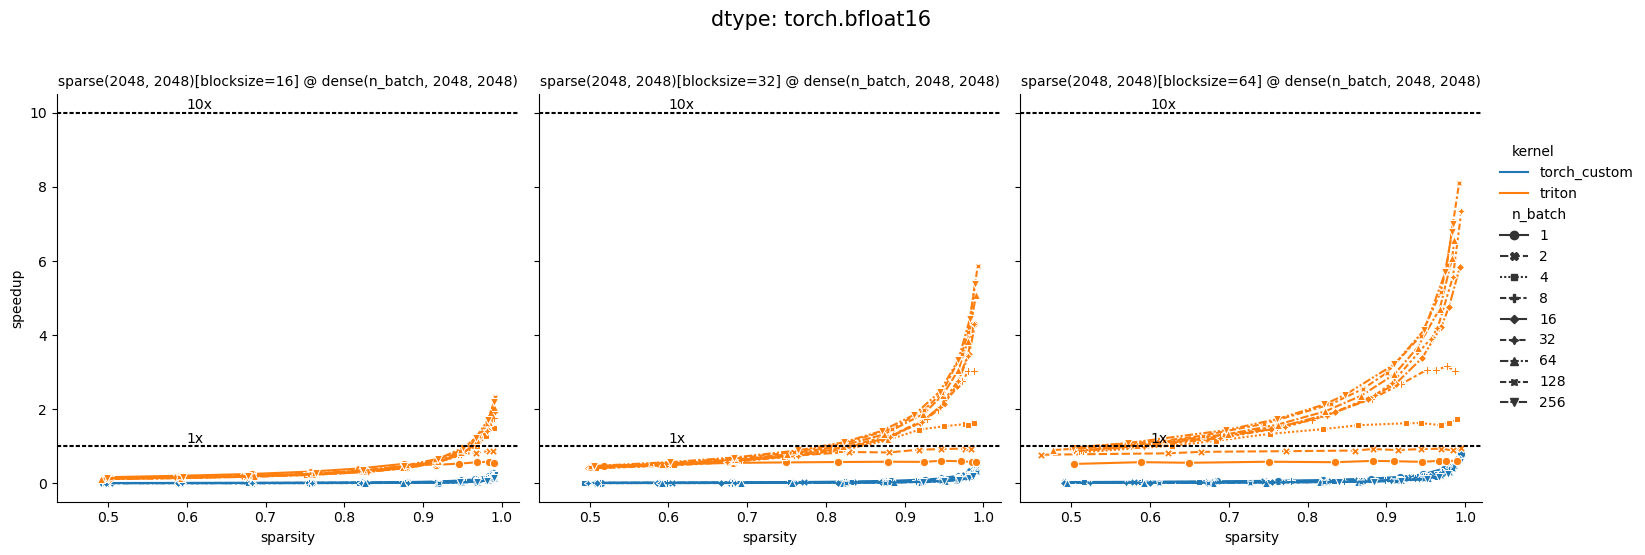

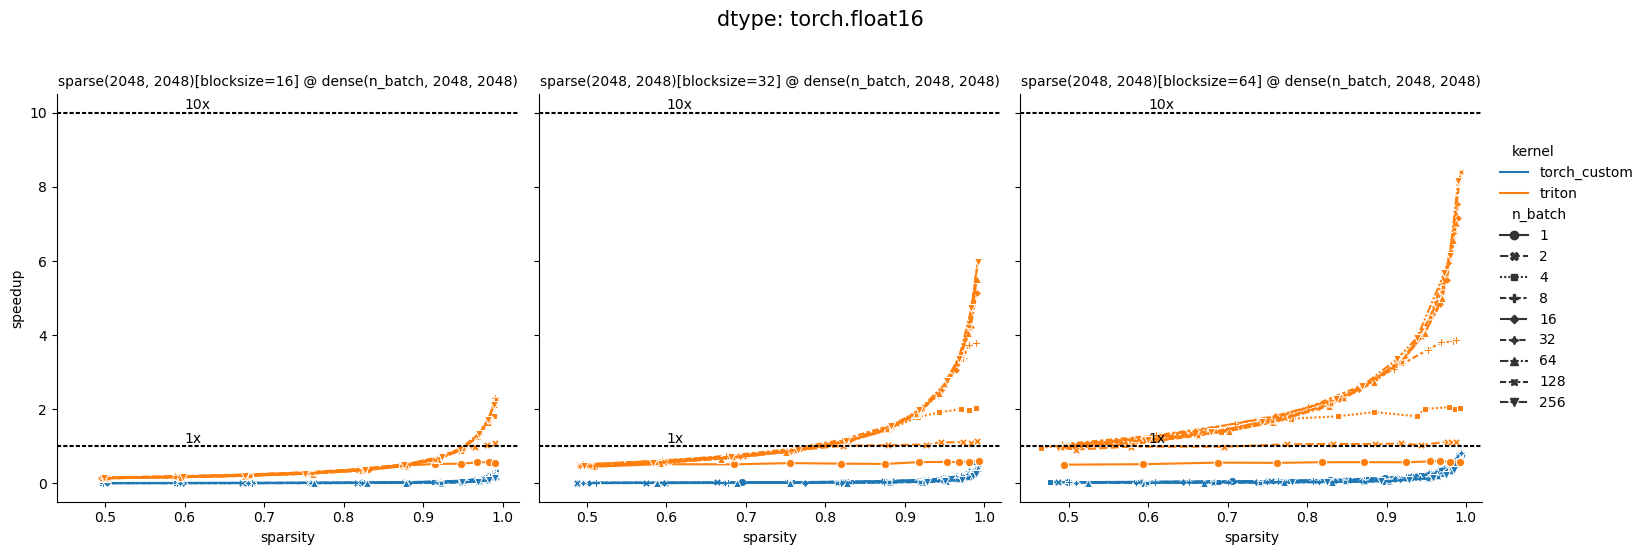

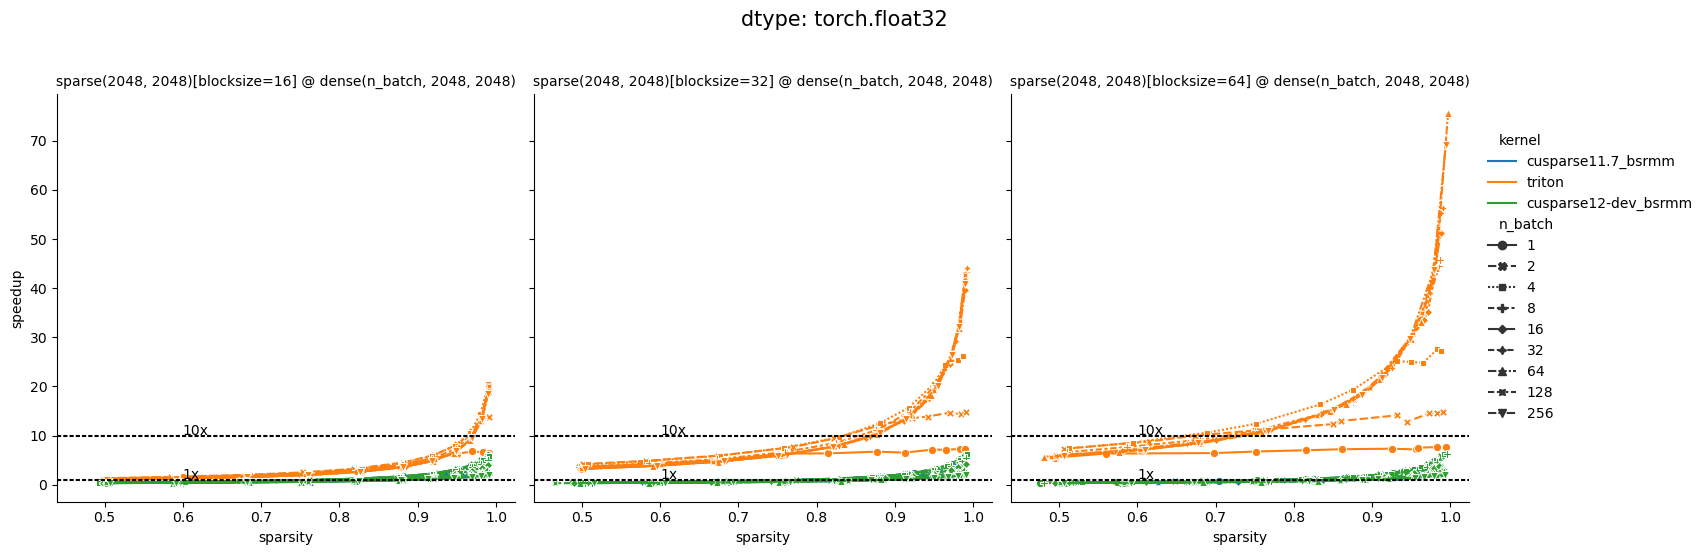

In [5]:
all_data.groupby('dtype').apply(lambda g: gen_dtype_figure(g, g.name))

In [6]:
all_data.groupby(['dtype','kernel']).apply(lambda g: g[g['speedup'] == g['speedup'].max()][['n_batch','blocksize', 'sparsity', 'speedup']]).reset_index(level=2, drop=True)

n_batch  blocksize  sparsity  speedup
dtype          kernel                                                     
torch.bfloat16 torch_custom                1         64  0.994141   0.7915
               triton                    128         64  0.992188   8.0933
torch.float16  torch_custom                8         64  0.993164   0.8534
               triton                    128         64  0.993164   8.3991
torch.float32  cusparse11.7_bsrmm          4         32  0.992432   6.3303
               cusparse12-dev_bsrmm        8         64  0.995117   6.2510
               triton                     64         64  0.997070  75.6993

In [27]:
(all_data.query('dtype == "torch.float32" & (kernel == "triton" | kernel == "cusparse11.7_bsrmm")')
 .groupby(['n_batch', 'blocksize', 'kernel'])
 .apply(lambda g: g.sort_values(by=['sparsity']).query('speedup > 1.0')[['sparsity', 'speedup']].head(1))
 .reset_index(level=3, drop=True))

sparsity  speedup
n_batch blocksize kernel                               
1       16        cusparse11.7_bsrmm  0.828430   1.2642
                  triton              0.497803   1.2414
        32        cusparse11.7_bsrmm  0.827393   1.2462
                  triton              0.496582   3.5814
        64        cusparse11.7_bsrmm  0.785156   1.0020
                  triton              0.495117   5.5420
2       16        cusparse11.7_bsrmm  0.822876   1.2464
                  triton              0.502136   1.3518
        32        cusparse11.7_bsrmm  0.819092   1.2174
                  triton              0.500977   4.1896
        64        cusparse11.7_bsrmm  0.819336   1.2007
                  triton              0.505859   7.3231
4       16        cusparse11.7_bsrmm  0.827637   1.2020
                  triton              0.500549   1.2981
        32        cusparse11.7_bsrmm  0.822021   1.1704
                  triton              0.508545   4.1341
        64        cusparse11.7_bsrmm  0.810547   1.1073
                  triton              0.512695   7.3830
8       16        cusparse11.7_bsrmm  0.826477   1.0595
                  triton              0.503357   1.1498
        32        cusparse11.7_bsrmm  0.826904   1.0647
                  triton              0.496094   3.6394
        64        cusparse11.7_bsrmm  0.830078   1.0869
                  triton              0.509766   6.6276
16      16        cusparse11.7_bsrmm  0.876892   1.2151
                  triton              0.496643   1.0090
        32        cusparse11.7_bsrmm  0.885742   1.2956
                  triton              0.498047   3.2931
        64        cusparse11.7_bsrmm  0.882812   1.2804
                  triton              0.493164   5.9225
32      16        cusparse11.7_bsrmm  0.877808   1.1073
                  triton              0.498962   1.0249
        32        cusparse11.7_bsrmm  0.874268   1.0925
                  triton              0.500732   3.2959
        64        cusparse11.7_bsrmm  0.876953   1.1202
                  triton              0.497070   5.9310
64      16        cusparse11.7_bsrmm  0.881531   1.0624
                  triton              0.499329   1.0210
        32        cusparse11.7_bsrmm  0.881348   1.0683
                  triton              0.500488   3.2381
        64        cusparse11.7_bsrmm  0.890625   1.1371
                  triton              0.481445   5.6962
128     16        cusparse11.7_bsrmm  0.919861   1.1617
                  triton              0.500488   1.0289
        32        cusparse11.7_bsrmm  0.912354   1.1213
                  triton              0.499268   3.1945
        64        cusparse11.7_bsrmm  0.925781   1.2248
                  triton              0.490234   5.7076
256     16        cusparse11.7_bsrmm  0.921570   1.1549
                  triton              0.502563   1.0247
        32        cusparse11.7_bsrmm  0.924561   1.1872
                  triton              0.504639   3.2147
        64        cusparse11.7_bsrmm  0.920898   1.1745
                  triton              0.505859   5.8598

In [12]:
for key, df in all_data.groupby(['dtype', 'kernel', 'n_batch', 'blocksize']):
    print(f"***{key}***")
    print(df.sort_values(by=['sparsity']).query('speedup > 1.0').head(1))

***('torch.bfloat16', 'torch_custom', 1, 16)***
Empty DataFrame
Columns: [kernel, dtype, size, blocksize, n_batch, sparsity, speedup]
Index: []
***('torch.bfloat16', 'torch_custom', 1, 32)***
Empty DataFrame
Columns: [kernel, dtype, size, blocksize, n_batch, sparsity, speedup]
Index: []
***('torch.bfloat16', 'torch_custom', 1, 64)***
Empty DataFrame
Columns: [kernel, dtype, size, blocksize, n_batch, sparsity, speedup]
Index: []
***('torch.bfloat16', 'torch_custom', 2, 16)***
Empty DataFrame
Columns: [kernel, dtype, size, blocksize, n_batch, sparsity, speedup]
Index: []
***('torch.bfloat16', 'torch_custom', 2, 32)***
Empty DataFrame
Columns: [kernel, dtype, size, blocksize, n_batch, sparsity, speedup]
Index: []
***('torch.bfloat16', 'torch_custom', 2, 64)***
Empty DataFrame
Columns: [kernel, dtype, size, blocksize, n_batch, sparsity, speedup]
Index: []
***('torch.bfloat16', 'torch_custom', 4, 16)***
Empty DataFrame
Columns: [kernel, dtype, size, blocksize, n_batch, sparsity, speedup]
In

In [29]:
(all_data
 .groupby(['n_batch', 'blocksize', 'kernel', 'dtype'])
 .apply(lambda g: g.sort_values(by=['sparsity']).query('speedup > 1.0')[['sparsity', 'speedup']].head(1))
 .reset_index(level=4, drop=True))

sparsity  speedup
n_batch blocksize kernel               dtype                            
1       16        cusparse11.7_bsrmm   torch.float32   0.828430   1.2642
                  cusparse12-dev_bsrmm torch.float32   0.826172   1.2470
                  triton               torch.float32   0.497803   1.2414
        32        cusparse11.7_bsrmm   torch.float32   0.827393   1.2462
                  cusparse12-dev_bsrmm torch.float32   0.825684   1.2394
                  triton               torch.float32   0.496582   3.5814
        64        cusparse11.7_bsrmm   torch.float32   0.785156   1.0020
                  cusparse12-dev_bsrmm torch.float32   0.814453   1.1008
                  triton               torch.float32   0.495117   5.5420
2       16        cusparse11.7_bsrmm   torch.float32   0.822876   1.2464
                  cusparse12-dev_bsrmm torch.float32   0.823608   1.2523
                  triton               torch.float16   0.980774   1.0254
                                       torch.float32   0.502136   1.3518
        32        cusparse11.7_bsrmm   torch.float32   0.819092   1.2174
                  cusparse12-dev_bsrmm torch.float32   0.773438   1.0056
                  triton               torch.float16   0.822510   1.0153
                                       torch.float32   0.500977   4.1896
        64        cusparse11.7_bsrmm   torch.float32   0.819336   1.2007
                  cusparse12-dev_bsrmm torch.float32   0.821289   1.2307
                  triton               torch.float16   0.775391   1.0521
                                       torch.float32   0.505859   7.3231
4       16        cusparse11.7_bsrmm   torch.float32   0.827637   1.2020
                  cusparse12-dev_bsrmm torch.float32   0.824829   1.1861
                  triton               torch.bfloat16  0.967896   1.0109
                                       torch.float16   0.968262   1.2430
                                       torch.float32   0.500549   1.2981
        32        cusparse11.7_bsrmm   torch.float32   0.822021   1.1704
                  cusparse12-dev_bsrmm torch.float32   0.821533   1.1673
                  triton               torch.bfloat16  0.878906   1.1706
                                       torch.float16   0.831055   1.1638
                                       torch.float32   0.508545   4.1341
        64        cusparse11.7_bsrmm   torch.float32   0.810547   1.1073
                  cusparse12-dev_bsrmm torch.float32   0.808594   1.1004
                  triton               torch.bfloat16  0.627930   1.0146
                                       torch.float16   0.627930   1.2493
                                       torch.float32   0.512695   7.3830
8       16        cusparse11.7_bsrmm   torch.float32   0.826477   1.0595
                  cusparse12-dev_bsrmm torch.float32   0.821106   1.0334
                  triton               torch.bfloat16  0.969727   1.1110
                                       torch.float16   0.969910   1.3357
                                       torch.float32   0.503357   1.1498
        32        cusparse11.7_bsrmm   torch.float32   0.826904   1.0647
                  cusparse12-dev_bsrmm torch.float32   0.823730   1.0484
                  triton               torch.bfloat16  0.884766   1.3108
                                       torch.float16   0.821533   1.1779
                                       torch.float32   0.496094   3.6394
        64        cusparse11.7_bsrmm   torch.float32   0.830078   1.0869
                  cusparse12-dev_bsrmm torch.float32   0.831055   1.0936
                  triton               torch.bfloat16  0.575195   1.0004
                                       torch.float16   0.492188   1.0575
                                       torch.float32   0.509766   6.6276
16      16        cusparse11.7_bsrmm   torch.float32   0.876892   1.2151
                  cusparse12-dev_bsrmm torch.float32   0.880981   1.2453
                  triton               t